In [1]:
## Boiler plate code common to many notebooks.  See the TestFilesCommonCode.ipynb for details
from __future__ import print_function
%run TestFilesCommonCode.ipynb

SimpleITK Version: 0.9.1
Compiled: Sep 28 2015 10:07:41



In [2]:
InputDir='/scratch/TESTS/Aim2/Inputs'
OutputDir='/scratch/TESTS/Aim2/Outputs'
MatlabFilesDir='/scratch/TESTS/Aim2/MatlabFiles'

label_fn = os.path.join(InputDir,'fswm_extended_neuro2012_20_merge_seg.nii.gz')
t1_fn = os.path.join(InputDir,'t1_average_BRAINSABC.nii.gz')
t2_fn = os.path.join(InputDir,'t2_average_BRAINSABC.nii.gz')
dwi_fn = os.path.join(InputDir,'DWI_Corrected_Aligned_CS.nrrd')
#dwi_fn = os.path.join(InputDir,'CorrectedDWI_in_T2Space.nrrd')

In [3]:
import os
import glob
import sys

#\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/
#####################################################################################
#     Prepend the shell environment search paths
PROGRAM_PATHS = '/scratch/NAMICExternalProjects/release_20150715/bin'
PROGRAM_PATHS = PROGRAM_PATHS.split(':')
PROGRAM_PATHS.extend(os.environ['PATH'].split(':'))
os.environ['PATH'] = ':'.join(PROGRAM_PATHS)

CUSTOM_ENVIRONMENT=dict()

# Platform specific information
#     Prepend the python search paths
PYTHON_AUX_PATHS = '/scratch/BS/BRAINSTools/AutoWorkup'
PYTHON_AUX_PATHS = PYTHON_AUX_PATHS.split(':')
PYTHON_AUX_PATHS.extend(sys.path)
sys.path = PYTHON_AUX_PATHS

import SimpleITK as sitk
import nipype
from nipype.interfaces.base import CommandLine, CommandLineInputSpec, TraitedSpec, File, Directory
from nipype.interfaces.base import traits, isdefined, BaseInterface
from nipype.interfaces.utility import Merge, Split, Function, Rename, IdentityInterface
import nipype.interfaces.io as nio   # Data i/oS
import nipype.pipeline.engine as pe  # pypeline engine
from nipype.interfaces.freesurfer import ReconAll
from SEMTools import *

In [4]:
from nipype.interfaces.ants import DenoiseImage

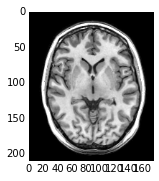

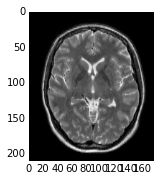

In [5]:
t1d = sitk.ReadImage(t1_fn)
t2d = sitk.ReadImage(t2_fn)

myshow(t1d)
myshow(t2d)

In [6]:
def ExtractBRAINFromHead(headImage, labelsMap):
    label_mask = labelsMap>0
    brainImage = sitk.Cast(headImage,sitk.sitkInt16) * sitk.Cast(label_mask,sitk.sitkInt16)
    return brainImage

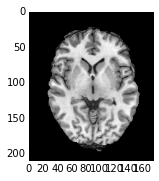

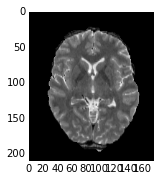

In [7]:
labelMap = sitk.ReadImage(label_fn)
t1d = ExtractBRAINFromHead(t1d,labelMap)
t2d = ExtractBRAINFromHead(t2d,labelMap)
myshow(t1d)
myshow(t2d)

In [8]:
# Now we read dwi image and extract its b0
myExtracter = extractNrrdVectorIndex()
myExtracter.inputs.inputVolume = dwi_fn
myExtracter.inputs.vectorIndex = 0
myExtracter.inputs.outputVolume = os.path.join(OutputDir,'dwi_b0.nrrd')
print(myExtracter.cmdline)
myExtracter.run()

INFO:interface:stdout 2016-01-13T20:57:21.636726:Input Image: /scratch/TESTS/Aim2/Inputs/DWI_Corrected_Aligned_CS.nrrd
INFO:interface:stdout 2016-01-13T20:57:21.636726:Output Image: /scratch/TESTS/Aim2/Outputs/dwi_b0.nrrd
INFO:interface:stdout 2016-01-13T20:57:21.636726:Vector Index: 0
INFO:interface:stdout 2016-01-13T20:57:21.636726:Set Image Orientation: AsAcquired
INFO:interface:stdout 2016-01-13T20:57:21.636726:


 extractNrrdVectorIndex  --inputVolume /scratch/TESTS/Aim2/Inputs/DWI_Corrected_Aligned_CS.nrrd --outputVolume /scratch/TESTS/Aim2/Outputs/dwi_b0.nrrd --vectorIndex 0


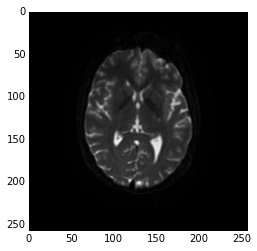

In [9]:
dwi_b0 = sitk.ReadImage(myExtracter.inputs.outputVolume)
myshow(dwi_b0)

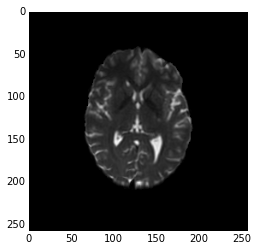

In [10]:
# Now resample the brain mask to normalized space to remove DWI skull
resampler2 = sitk.ResampleImageFilter()
resampler2.SetReferenceImage(dwi_b0)
resampler2.SetInterpolator(sitk.sitkNearestNeighbor)
labelMap = resampler2.Execute(labelMap)

dwi_b0 = ExtractBRAINFromHead(dwi_b0,labelMap)
myshow(dwi_b0)

In [11]:
# Now t1d and t2d have original t1, t2 voxel lattice with following specifications:
print(t1d.GetSize())
print(t2d.GetSize())
print(t1d.GetDirection())
print(t2d.GetDirection())
print(t1d.GetOrigin())
print(t2d.GetOrigin())

(174, 208, 186)
(174, 208, 186)
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
(-88.5, -88.5, -89.5)
(-88.5, -88.5, -89.5)


In [12]:
print(dwi_b0.GetSize())
print(dwi_b0.GetDirection())
print(dwi_b0.GetOrigin())

(256, 256, 61)
(0.9918539561569646, 0.05181217926069737, 0.11636678106760484, -0.028214547076287348, 0.9802080203863694, -0.19594942230972467, -0.12421621870375261, 0.19106997370202405, 0.9736850600478829)
(-140.12465793097655, -86.4420614591275, -72.24374524354596)


In [13]:
############################
# Now JUST FOR MATLAB TEST:
############################
# resample t1d and t2d to DWI space (256x256x61)
#
resampler1 = sitk.ResampleImageFilter()
resampler1.SetReferenceImage(dwi_b0)
t1d = resampler1.Execute(t1d)
t2d = resampler1.Execute(t2d)

print(t1d.GetSize())
print(t2d.GetSize())
print(t1d.GetDirection())
print(t2d.GetDirection())
print(t1d.GetOrigin())
print(t2d.GetOrigin())

(256, 256, 61)
(256, 256, 61)
(0.9918539561569646, 0.05181217926069737, 0.11636678106760484, -0.028214547076287348, 0.9802080203863694, -0.19594942230972467, -0.12421621870375261, 0.19106997370202405, 0.9736850600478829)
(0.9918539561569646, 0.05181217926069737, 0.11636678106760484, -0.028214547076287348, 0.9802080203863694, -0.19594942230972467, -0.12421621870375261, 0.19106997370202405, 0.9736850600478829)
(-140.12465793097655, -86.4420614591275, -72.24374524354596)
(-140.12465793097655, -86.4420614591275, -72.24374524354596)


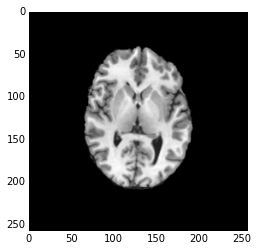

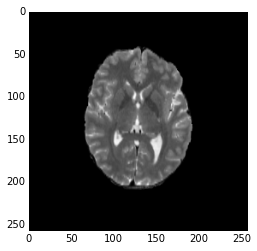

In [14]:
myshow(t1d)
myshow(t2d)

In [15]:
# Now set direction cosign of all images to identity
def ForceDCtoID(inputVolume):
    import os
    import SimpleITK as sitk
    inputVolume.SetDirection((1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0))
    return inputVolume

def ForceOriginToZero(inputVolume):
    import os
    import SimpleITK as sitk
    inputVolume.SetOrigin((0.0, 0.0, 0.0))
    return inputVolume

In [16]:
dwi_b0 = ForceDCtoID(dwi_b0)
dwi_b0 = ForceOriginToZero(dwi_b0)

t1d = ForceDCtoID(t1d)
t1d = ForceOriginToZero(t1d)

t2d = ForceDCtoID(t2d)
t2d = ForceOriginToZero(t2d)

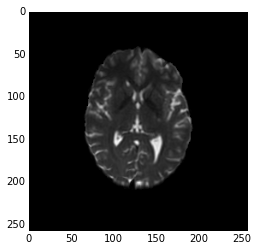

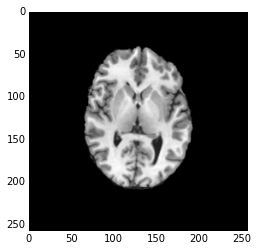

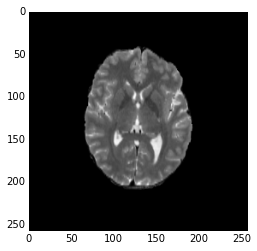

In [17]:
myshow(dwi_b0)
myshow(t1d)
myshow(t2d)

In [18]:
print(t1d.GetSize())
print(t1d.GetDirection())
print(t1d.GetOrigin())

print(t2d.GetSize())
print(t2d.GetDirection())
print(t2d.GetOrigin())

print(dwi_b0.GetSize())
print(dwi_b0.GetDirection())
print(dwi_b0.GetOrigin())

(256, 256, 61)
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
(0.0, 0.0, 0.0)
(256, 256, 61)
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
(0.0, 0.0, 0.0)
(256, 256, 61)
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
(0.0, 0.0, 0.0)


In [19]:
# NOW run an Affine registration for t1d -> dwi_b0 & t2d -> dwi_b0

# Set the registration filter
fixed = sitk.Cast(dwi_b0, sitk.sitkFloat32)
moving = sitk.Cast(t2d, sitk.sitkFloat32)

tx = sitk.AffineTransform(fixed.GetDimension())
ctx = sitk.Transform(tx)
ctx.SetFixedParameters(ctx.GetFixedParameters())

R = sitk.ImageRegistrationMethod()
R.SetInitialTransform(ctx)
R.SetMetricAsMattesMutualInformation( 200 )
R.SetShrinkFactorsPerLevel([1])
R.SetSmoothingSigmasPerLevel([0])
R.SetInterpolator(sitk.sitkLinear)
R.SetMetricSamplingPercentage(0.5)
R.SetMetricSamplingStrategy(R.RANDOM)
R.SetOptimizerAsConjugateGradientLineSearch(learningRate=1.0,
                                            numberOfIterations=250,
                                            convergenceMinimumValue=1e-6,
                                            convergenceWindowSize=10,
                                            lineSearchLowerLimit=0,
                                            lineSearchUpperLimit=2,
                                            lineSearchEpsilon=0.2,
                                            lineSearchMaximumIterations=20,
                                            estimateLearningRate=R.EachIteration,
                                            maximumStepSizeInPhysicalUnits=1.0)
R.SetOptimizerScalesFromPhysicalShift()
R.RemoveAllCommands()
R.AddCommand( sitk.sitkIterationEvent, lambda: command_iteration(R) )
affineOut = R.Execute(fixed,moving)
print("-------")
print(affineOut)
print("Optimizer stop condition: {0}".format(R.GetOptimizerStopConditionDescription()))
print(" Iteration: {0}".format(R.GetOptimizerIteration()))
print(" Metric value: {0}".format(R.GetMetricValue()))

0 = -0.517189651595 : (0.9999770873456497, 1.082758706546436e-05, 5.30609232261875e-06, -3.6373024921586224e-05, 0.9999459133473176, -4.076722675467904e-05, -4.593439968407412e-05, -4.298467991121916e-05, 0.999880410401804, 0.0018011698118459581, -0.021130122297367427, -0.023961632038216513)
1 = -0.517364686948 : (0.9999768122076447, 1.0986309211936705e-05, 5.376613858256214e-06, -3.668954233163914e-05, 0.9999453750885867, -4.105085150641702e-05, -4.620034778979146e-05, -4.322471783559629e-05, 0.9998794714005858, 0.001832820246685127, -0.021325603063387433, -0.02410371763254322)
2 = -0.517364948749 : (0.9999767024029032, 1.1049633086052939e-05, 5.404778674333453e-06, -3.6815112724073896e-05, 0.9999451610438412, -4.116267244714724e-05, -4.6305619994322115e-05, -4.331965977976548e-05, 0.9998790981723791, 0.001845438546338958, -0.021403235672842837, -0.024159990693918682)
3 = -0.517364939724 : (0.999976631487198, 1.1090524900717745e-05, 5.422972964986566e-06, -3.689601978813212e-05, 0.999

<bound method ResampleImageFilter.GetTransform of <SimpleITK.SimpleITK.ResampleImageFilter; proxy of <Swig Object of type 'itk::simple::ResampleImageFilter::Self *' at 0x11d48b2a0> >>


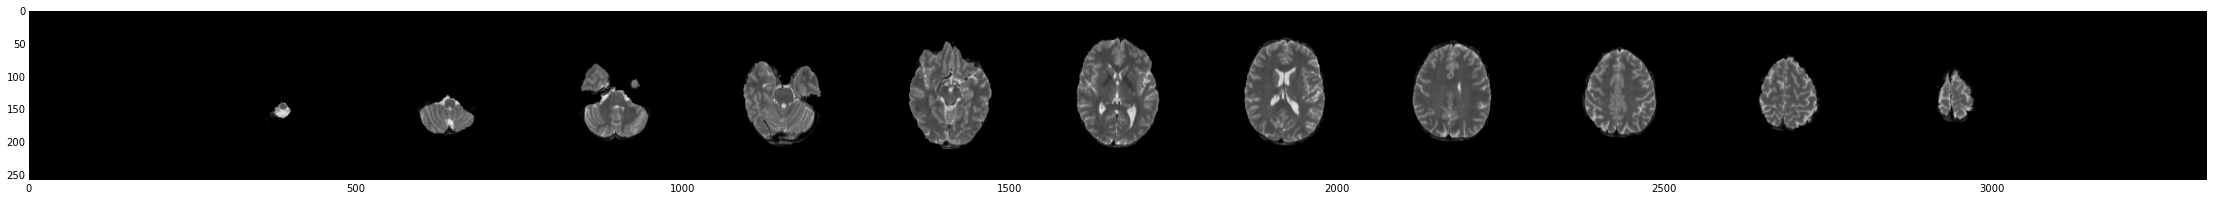

In [20]:
cshow3d(fixed,moving,ctx)

In [21]:
res = sitk.ResampleImageFilter()
res.SetTransform(ctx)
res.SetReferenceImage(dwi_b0)
t1d = res.Execute(t1d)
t2d = res.Execute(t2d)

In [22]:
# Write images to the disk for checking their alignment in slicer
sitk.WriteImage(t1d,os.path.join(OutputDir,'t1_inVoxelSpace.nii.gz'))
sitk.WriteImage(t2d,os.path.join(OutputDir,'t2_inVoxelSpace.nii.gz'))
sitk.WriteImage(dwi_b0,os.path.join(OutputDir,'dwi_b0_inVoxelSpace.nii.gz'))

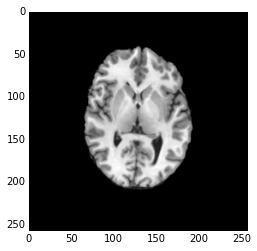

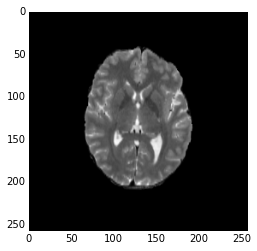

In [23]:
myshow(t1d)
myshow(t2d)

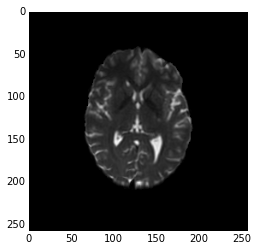

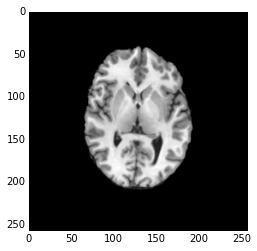

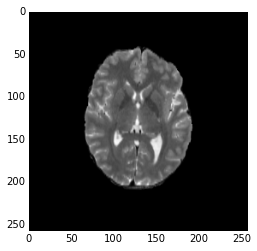

In [24]:
#
#
# Now we follow all processes in 2D space
# 's' means slice
t1d_s = t1d[:,:,t1d.GetSize()[2]/2]
t2d_s = t2d[:,:,t2d.GetSize()[2]/2]
dwib0_s = dwi_b0[:,:,dwi_b0.GetSize()[2]/2]

myshow(dwib0_s)
myshow(t1d_s)
myshow(t2d_s)
#
#

In [25]:
# Now we have following goals:
# 1) save the axial 2d dwi file (dwib0_s) as a matlab file in "MatlabFiles" directory.
# 2) Create edge mask from cobinations of t1d_s and t2d_s

In [161]:
def NormalizeBetweenZeroAndOne(image):
    image_double = sitk.Cast(image, sitk.sitkFloat32)
    #image_double = image_double/4096 + 100000
    #image_double[0,0] = 0
    #image_double[0,1] = 1000000
    # new range
    newMax=1.0
    newMin=0
    # Find old range
    totalStats = sitk.StatisticsImageFilter()
    totalStats.Execute(image_double)
    oldMax=totalStats.GetMaximum()
    oldMin=totalStats.GetMinimum()
    f=(newMax-newMin)/(oldMax-oldMin)
    Normalized_image = (image_double-oldMin)*f+newMin
    return Normalized_image

In [162]:
# GOAL 1

In [163]:
print(dwib0_s.GetSize())
print(dwib0_s.GetSpacing())

#print(dwib0_s.GetPixelIDTypeAsString())
# This step is important because "Undefined function 'fftn' for input arguments of type 'int16'"
#dwib0_s = sitk.Cast(dwib0_s, sitk.sitkUInt16)
#print(dwib0_s.GetPixelIDTypeAsString())


# Now normalize dwi_b0 to have values between 0 and 1
dwib0_s = NormalizeBetweenZeroAndOne(dwib0_s)
dwi_im_arr = sitk.GetArrayFromImage(dwib0_s)

import scipy.io
scipy.io.savemat(os.path.join(MatlabFilesDir,'dwib0_testdata.mat'), mdict={'inputImage': dwi_im_arr})

(256, 256)
(1.0, 1.0000000000000004)


In [164]:
# GOAL 2

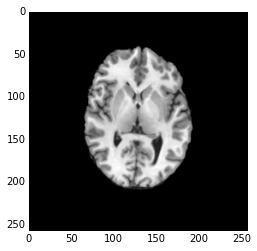

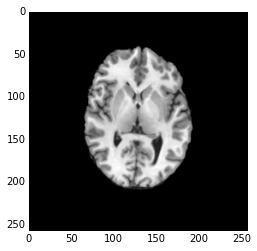

In [165]:
myshow(t1d_s)
t1d_s_n = NormalizeBetweenZeroAndOne(t1d_s)
myshow(t1d_s_n)
t1_im_arr = sitk.GetArrayFromImage(t1d_s_n)
scipy.io.savemat(os.path.join(MatlabFilesDir,'t1_testdata.mat'), mdict={'inputImage': t1_im_arr})

In [166]:
t2d_s_n = NormalizeBetweenZeroAndOne(t2d_s)
t2_im_arr = sitk.GetArrayFromImage(t2d_s_n)
scipy.io.savemat(os.path.join(MatlabFilesDir,'t2_testdata.mat'), mdict={'inputImage': t2_im_arr})

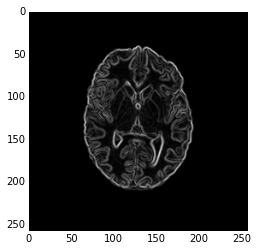

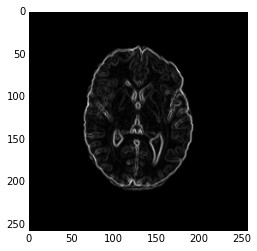

In [167]:
# Find edges based on gradient magnitude
t1g = sitk.GradientMagnitude(t1d_s)
t2g = sitk.GradientMagnitude(t2d_s)
myshow(t1g)
myshow(t2g)

In [168]:
#sitk.WriteImage(t1g,os.path.join(OutputDir,'gradMag_t1_denoised.nii.gz'))
#sitk.WriteImage(t2g,os.path.join(OutputDir,'gradMag_t2_denoised.nii.gz'))

In [169]:
stats = sitk.StatisticsImageFilter()
stats.Execute(t1g)
t1gMax = stats.GetMaximum()
t1gMean = stats.GetMean()

stats.Execute(t2g)
t2gMax = stats.GetMaximum()
t2gMean = stats.GetMean()

print(t1gMax)
print(t2gMax)
print(t1gMean)
print(t2gMean)

1710.16442871
1630.67358398
73.1134635905
47.487703102


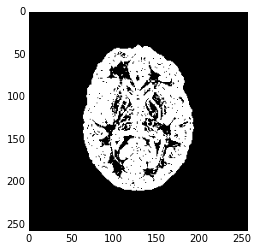

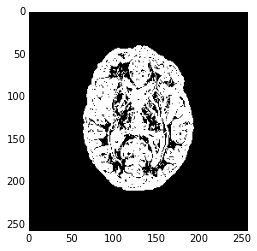

In [170]:
#maskROI1 = t1g > t1gMax/10
#maskROI2 = t2g > t1gMax/10

maskROI1 = t1g > t1gMean
maskROI2 = t2g > t2gMean

myshow(maskROI1)
myshow(maskROI2)

In [171]:
mask1 = maskROI1 & maskROI2
mask2 = maskROI1 | maskROI2

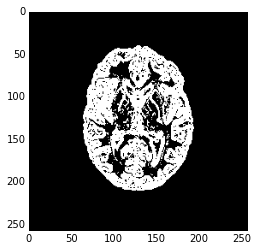

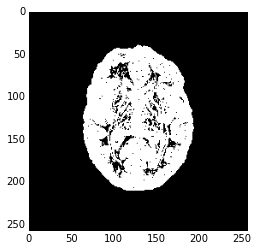

In [172]:
myshow(mask1)
myshow(mask2)

In [173]:
Lstat = sitk.LabelStatisticsImageFilter()
Lstat.Execute(t1g,mask1)
t1_avg_1 = Lstat.GetMean(1)
print("t1 average 1: {0}".format(t1_avg_1))

Lstat.Execute(t1g,mask2)
t1_avg_2 = Lstat.GetMean(1)
print("t1 average 2: {0}".format(t1_avg_2))

t1 average 1: 363.512470955
t1 average 2: 308.950115096


In [174]:
Lstat.Execute(t2g,mask1)
t2_avg_1 = Lstat.GetMean(1)
print("t2 average 1: {0}".format(t2_avg_1))

Lstat.Execute(t2g,mask2)
t2_avg_2 = Lstat.GetMean(1)
print("t2 average 2: {0}".format(t2_avg_2))

t2 average 1: 239.381600515
t2 average 2: 200.588390743


In [175]:
# find m and b for "t2 = m * t1 + b"
m = (t2_avg_1-t2_avg_2)/(t1_avg_1-t1_avg_2)
print(m)

b = t2_avg_1 - (m*t1_avg_1)
print(b)

0.710988540758
-19.0716007561


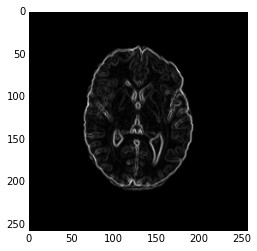

In [176]:
# t2 = m * t1 + b
# t2' = m' * t1
# if m'=1 --> t2' = (t2-b)/m
# linearize
t2gl = (t2g - b)/m
myshow(t2gl)

In [177]:
totalStats = sitk.StatisticsImageFilter()

totalStats.Execute(t1g)
print(totalStats.GetMaximum())
print(totalStats.GetMinimum())
print(totalStats.GetMean())

totalStats.Execute(t2gl)
print(totalStats.GetMaximum())
print(totalStats.GetMinimum())
print(totalStats.GetMean())

1710.16442871
0.0
73.1134635905
2320.35424805
26.8240623474
93.6151582734


In [178]:
Lstat.Execute(t1g,mask1)
t1_avg_1 = Lstat.GetMean(1)
print("t1 average 1: {0}".format(t1_avg_1))
Lstat.Execute(t2gl,mask1)
t2L_avg_1 = Lstat.GetMean(1)
print("t2_L average 1: {0}".format(t1_avg_1))

t1 average 1: 363.512470955
t2_L average 1: 363.512470955


1775.10791016
13.4120311737


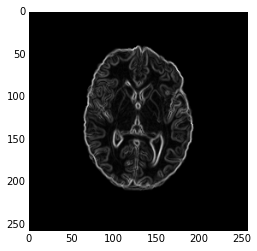

In [199]:
########################################
#### EDGE MASK STARTS FROM HERE ########
########################################

edgeMask = (t1g+t2gl)/2
myshow(edgeMask)

totalStats = sitk.StatisticsImageFilter()
totalStats.Execute(edgeMask)
print(totalStats.GetMaximum())
print(totalStats.GetMinimum())

1.0
0.0


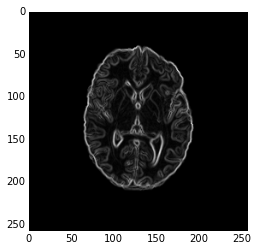

In [200]:
edgeMask = NormalizeBetweenZeroAndOne(edgeMask)
myshow(edgeMask)

totalStats = sitk.StatisticsImageFilter()
totalStats.Execute(edgeMask)
print(totalStats.GetMaximum())
print(totalStats.GetMinimum())

In [201]:
#med = sitk.MedianImageFilter()
#edgeMask = med.Execute(edgeMask)
#myshow(edgeMask)

In [202]:
#edgeMask = sitk.Square(edgeMask)
#myshow(edgeMask)

3.40282346639e+38
1.0


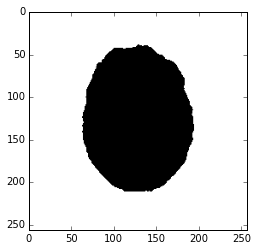

In [203]:
# compute 1/grad(x)
div = sitk.DivideImageFilter()
edgeMask = div.Execute(1,edgeMask)
myshow(edgeMask)

totalStats = sitk.StatisticsImageFilter()
totalStats.Execute(edgeMask)
print(totalStats.GetMaximum())
print(totalStats.GetMinimum())

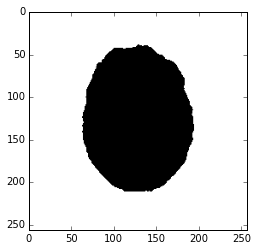

In [204]:
# Now normalize both t1g and t2g to have values between 0 and 1
edgeMask = NormalizeBetweenZeroAndOne(edgeMask)
myshow(edgeMask)

#edgeMask = sitk.Square(edgeMask)
#myshow(edgeMask)

In [205]:
'''
# use mask dilation
dil = sitk.GrayscaleDilateImageFilter()
dilatedEdgeMask = dil.Execute(edgeMask)
myshow(dilatedEdgeMask)

#edgeMask = dilatedEdgeMask
'''

'\n# use mask dilation\ndil = sitk.GrayscaleDilateImageFilter()\ndilatedEdgeMask = dil.Execute(edgeMask)\nmyshow(dilatedEdgeMask)\n\n#edgeMask = dilatedEdgeMask\n'

In [206]:
'''
# invert the edge mask
inverter = sitk.InvertIntensityImageFilter()
edgeMask = inverter.Execute(edgeMask,1)
'''

'\n# invert the edge mask\ninverter = sitk.InvertIntensityImageFilter()\nedgeMask = inverter.Execute(edgeMask,1)\n'

In [207]:
totalStats = sitk.StatisticsImageFilter()
totalStats.Execute(edgeMask)
print(totalStats.GetMaximum())
print(totalStats.GetMinimum())

0.999999940395
0.0


In [208]:
'''
myshow(edgeMask)

sqredgeMask = sitk.Square(edgeMask)
sqredgeMask = sitk.Square(sqredgeMask)
sqredgeMask = sitk.Square(sqredgeMask)
sqredgeMask = sitk.Square(sqredgeMask)
sqredgeMask = sitk.Square(sqredgeMask)
sqredgeMask = sitk.Square(sqredgeMask)
sqredgeMask = sitk.Square(sqredgeMask)

sqredgeMask = sitk.Square(sqredgeMask)

myshow(sqredgeMask)
'''

'\nmyshow(edgeMask)\n\nsqredgeMask = sitk.Square(edgeMask)\nsqredgeMask = sitk.Square(sqredgeMask)\nsqredgeMask = sitk.Square(sqredgeMask)\nsqredgeMask = sitk.Square(sqredgeMask)\nsqredgeMask = sitk.Square(sqredgeMask)\nsqredgeMask = sitk.Square(sqredgeMask)\nsqredgeMask = sitk.Square(sqredgeMask)\n\nsqredgeMask = sitk.Square(sqredgeMask)\n\nmyshow(sqredgeMask)\n'

In [209]:
'''
# rotate the edgemask a little intentionally!
rigTx = sitk.Euler2DTransform()
rigTx.SetAngle(0.017*7)

resampler3 = sitk.ResampleImageFilter()
resampler3.SetReferenceImage(edgeMask)
resampler3.SetTransform(rigTx)
resampler3.SetDefaultPixelValue(1)
newedgeMask = resampler3.Execute(sqredgeMask)
myshow(newedgeMask)
'''

'\n# rotate the edgemask a little intentionally!\nrigTx = sitk.Euler2DTransform()\nrigTx.SetAngle(0.017*7)\n\nresampler3 = sitk.ResampleImageFilter()\nresampler3.SetReferenceImage(edgeMask)\nresampler3.SetTransform(rigTx)\nresampler3.SetDefaultPixelValue(1)\nnewedgeMask = resampler3.Execute(sqredgeMask)\nmyshow(newedgeMask)\n'

In [210]:
edge_arr = sitk.GetArrayFromImage(edgeMask)
#edge_arr = sitk.GetArrayFromImage(sqredgeMask)

import scipy.io
scipy.io.savemat(os.path.join(MatlabFilesDir,'edgemask_t1t2_gm_div_nonorm.mat'), mdict={'edgemask': edge_arr})